# Wavelet Magic

In this notebook, we try to develop Devnagari Charecter based language model which generate meaningful Marathi Names internally uses Neural Network. 
Here we are partially following approach mentioned in this [paper](https://arxiv.org/abs/1609.03499)
As mentioned in paper Wavenet network is used for generating raw audio waveforms. We are using wavenet structure mentioned in paper to calculate relationship between charecters in words of training set. Wavenet creates hierarchical structure which considers consecutive substructure (subwords and combinations of subwords) to predict next part of structure (in our case next charecter).

As we do in previous attempts, we are load necessary libraries and create input dataset and other data structures.

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
more_words = open('more_names.txt', 'r').read().splitlines()
words[:8]

['अंकबरीश', 'अकलंक', 'अंकित', 'अंकुज', 'अंकुर', 'अंकुश', 'अंकेश', 'अक्रूर']

In [3]:
words1 = [word.strip() for word in words]
words1.extend([word.strip() for word in more_words])
words = list(set(words1))

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'ँ', 2: 'ं', 3: 'ः', 4: 'अ', 5: 'आ', 6: 'इ', 7: 'ई', 8: 'उ', 9: 'ऊ', 10: 'ऋ', 11: 'ए', 12: 'ऐ', 13: 'ओ', 14: 'औ', 15: 'क', 16: 'ख', 17: 'ग', 18: 'घ', 19: 'च', 20: 'छ', 21: 'ज', 22: 'झ', 23: 'ञ', 24: 'ट', 25: 'ठ', 26: 'ड', 27: 'ढ', 28: 'ण', 29: 'त', 30: 'थ', 31: 'द', 32: 'ध', 33: 'न', 34: 'प', 35: 'फ', 36: 'ब', 37: 'भ', 38: 'म', 39: 'य', 40: 'र', 41: 'ल', 42: 'ळ', 43: 'ऴ', 44: 'व', 45: 'श', 46: 'ष', 47: 'स', 48: 'ह', 49: '़', 50: 'ा', 51: 'ि', 52: 'ी', 53: 'ु', 54: 'ू', 55: 'ृ', 56: 'ॅ', 57: 'े', 58: 'ै', 59: 'ॉ', 60: 'ो', 61: 'ौ', 62: '्', 63: 'क़', 64: 'ज़', 65: 'फ़', 0: '.'}
66


In [5]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

We will use input block size of 8 charecters. This is one of the hyperparameter which can affect result.

In [6]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([61266, 8]) torch.Size([61266])
torch.Size([7615, 8]) torch.Size([7615])
torch.Size([7675, 8]) torch.Size([7675])


In [7]:
for val in Xtr[:50]:
    line = []
    for v in val:
        line.append(itos[int(v)])
    print(''.join(line))    

........
.......क
......कु
.....कुस
....कुसु
...कुसुम
..कुसुम्
.कुसुम्ल
कुसुम्लत
ुसुम्लत्
सुम्लत्त
ुम्लत्ता
........
.......थ
......थब
.....थबि
....थबित
........
.......च
......चं
.....चंद
....चंदू
........
.......क
......कौ
.....कौस
....कौसल
........
.......ख
......खी
.....खीम
........
.......म
......मे
.....मेह
....मेह्
...मेह्त
..मेह्तो
........
.......र
......रह
.....रहि
....रहिस
...रहिसु
..रहिसुद
.रहिसुद्
रहिसुद्द
हिसुद्दि
िसुद्दिन
........


In [8]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> क
.......क --> ु
......कु --> स
.....कुस --> ु
....कुसु --> म
...कुसुम --> ्
..कुसुम् --> ल
.कुसुम्ल --> त
कुसुम्लत --> ्
ुसुम्लत् --> त
सुम्लत्त --> ा
ुम्लत्ता --> .
........ --> थ
.......थ --> ब
......थब --> ि
.....थबि --> त
....थबित --> .
........ --> च
.......च --> ं
......चं --> द


Now we are ready to create scaffold of model i.e. structure of Neural Network.
* Linear layer is straight forward, it takes fan_in, fan_out and bias value to create linear layer which is nothing but weighted addition of input feature with addition of bias.
* BatchNorm1d is batch normalization layer for 1 dimentional data. Here we are making all arrangement for handling of multi dimentional layer data. It will make layer data in gaussian distribution.
* Tanh is activation layer.
* FlattenConsecutive layer flatten multi dimentional data and help to create wavenet structure.
* Sequential layer combines above all layers in various combinations.

In [10]:
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:
  
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))
    
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:
  
  def __init__(self, n):
    self.n = n
    
  def __call__(self, x):
    B, T, C = x.shape
    #print("shape : ",B,T,C)
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Sequential:
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

Define seed for reproducibility of same random ( funny oxymoran ...) data.

In [11]:
torch.manual_seed(42); # seed rng for reproducibility

Now this is actual model for Character based language model with wavenet structure.

In [12]:
# original network
# n_embd = 10 # the dimensionality of the character embedding vectors
# n_hidden = 300 # the number of neurons in the hidden layer of the MLP
# model = Sequential([
#   Embedding(vocab_size, n_embd),
#   FlattenConsecutive(8), Linear(n_embd * 8, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(n_hidden, vocab_size),
# ])

# hierarchical network
n_embd = 128 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP
model = Sequential([
  Embedding(vocab_size, n_embd),
  FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

116034


And this is training loop.

In [13]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 1000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 4.1901
   1000/ 200000: 2.5581
   2000/ 200000: 3.0448
   3000/ 200000: 2.6125
   4000/ 200000: 2.1467
   5000/ 200000: 2.1291
   6000/ 200000: 2.1532
   7000/ 200000: 1.5999
   8000/ 200000: 2.1660
   9000/ 200000: 1.8441
  10000/ 200000: 2.8791
  11000/ 200000: 1.8204
  12000/ 200000: 2.2962
  13000/ 200000: 2.1013
  14000/ 200000: 1.7158
  15000/ 200000: 2.0088
  16000/ 200000: 1.9064
  17000/ 200000: 1.8276
  18000/ 200000: 1.9163
  19000/ 200000: 2.1326
  20000/ 200000: 2.3464
  21000/ 200000: 1.8420
  22000/ 200000: 2.2070
  23000/ 200000: 2.1560
  24000/ 200000: 1.6909
  25000/ 200000: 1.4541
  26000/ 200000: 1.5546
  27000/ 200000: 2.0411
  28000/ 200000: 2.0361
  29000/ 200000: 1.8480
  30000/ 200000: 2.4198
  31000/ 200000: 1.9858
  32000/ 200000: 2.4610
  33000/ 200000: 1.5994
  34000/ 200000: 2.1115
  35000/ 200000: 1.9214
  36000/ 200000: 2.0740
  37000/ 200000: 1.7450
  38000/ 200000: 2.2701
  39000/ 200000: 1.9320
  40000/ 200000: 1.9636
  41000/ 200000:

This is batchwise loss value graph.

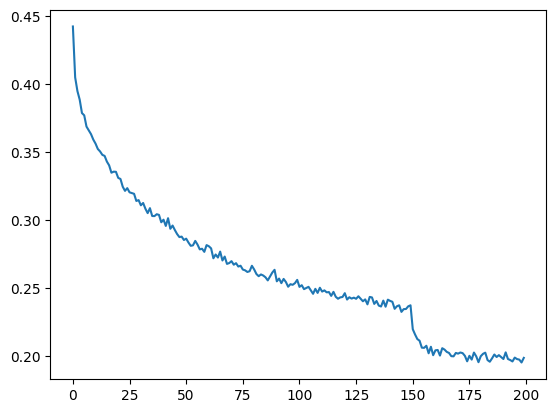

In [14]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [15]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

Making Neural Network effective and accurate is perfect balancing act.


As per training and validation loss, we need to lots of work.

In [16]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.5138345956802368
val 2.789623737335205


In [17]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Here is final output for now, some names come out after all hustle.

In [18]:
# sample from the model
for _ in range(10):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

पर्श्वर.
मोह्मि.
मोशत.
हन्द्रि.
मिश्रि.
शेरा.
हर्षद.
हुर्य.
दिन.
उर्मिला.
